In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import json
import datetime
import numpy as np
import pyodbc

In [2]:
f = open('./drainage_meta_data.json', encoding='utf-8')
df = pd.DataFrame(json.load(f)['sensors'])
df.head(2)

,name:,ID,flow,combined_flow,level,veita,downstream,upstream
0,Seilugrandi,RVK-SEI,[RS111],[],[HS111],Skerjafjarðarveita,[RVK-ANA],[]
1,Boðagrandi,RVK-BOD,[RS111],[],[HS111],Skerjafjarðarveita,[RVK-ANA],[]


In [3]:
def sensor_data_query(ID, sensor_names):
    full_sensor_names = []
    for s_name in sensor_names:
        f_name = 'F-' + ID + '-' + s_name
        full_sensor_names.append(f_name)
    
    added_quotes = ["'" + i + "'" for i in full_sensor_names]
    query = \
    f'''SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ({", ".join(added_quotes)})'''
    return query

def execute_query(query):
    
    sql_conn = pyodbc.connect("""DRIVER={SQL Server};
                                SERVER=VHG;
                                DATABASE=Kerfiradur_mirror;
                                Trusted_Connection=yes""") 

    results = pd.read_sql(query, sql_conn, parse_dates=['ctime','date_time','value_dates'])
    return results

In [4]:
has_combined = df.loc[:,'combined_flow'].apply(len) > 0

get_flow = lambda x : sensor_data_query(x['ID'], x['flow'])
get_combined = lambda x : sensor_data_query(x['ID'], x['combined_flow'])
get_level = lambda x : sensor_data_query(x['ID'], x['level'])

df.loc[:,'flow_query'] = df.apply(get_flow,axis=1)
df.loc[:,'level_query'] = df.apply(get_level,axis=1)
df.loc[has_combined,'flow_query'] = df.loc[has_combined].apply(get_combined,axis=1)


In [5]:
for index,ID in df.loc[:,'ID'].iteritems():
    print(df.loc[index,'flow_query'])
    

SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-RVK-SEI-RS111')
SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-RVK-BOD-RS111')
SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-RVK-VES-RS111')
SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-KOP-HAB-RS101')
SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-RVK-SKE-RS101', 'F-RVK-SKE-RS102', 'F-RVK-SKE-RS103', 'F-RVK-SKE-RS104')
SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-RVK-FAX-RS101', 'F-RVK-FAX-RS102', 'F-RVK-FAX-RS103', 'F-RVK-FAX-RS104')
SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-RVK-ANA-RS301-RS')
SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-MOS-HOL-RS101', 'F-MOS-HOL-RS102', 'F-MOS-HOL-RS-103')
SELECT * FROM  Kerfiradur_mirror.veitur_abb_db1.hour WHERE NAME IN ('F-RVK-ING-RS101', 'F-RVK-ING-RS102', 'F-RVK-ING-RS103')
SELECT * FROM  Kerfirad

In [6]:
# df

In [9]:
list_flow = []
list_level = []
SAVE_DIR = './raw data/'
for index,row in df.iloc[[7]].iterrows():
    ID = row['ID']
    filename_flow = SAVE_DIR + f'F-{ID}-RS'
    filename_level = SAVE_DIR + f'F-{ID}-HS'
    
    flow_query = df.loc[index,'flow_query']
    data_flow = execute_query(flow_query)
    # data_flow.to_pickle(filename_flow)
    
    # sometimes no level meter
    if len(row['level']) == 0:
        pd.DataFrame().to_pickle(filename_level)
    else:
        level_query = df.loc[index,'level_query']
        data_level = execute_query(level_query)
        # data_level.to_pickle(filename_level)
        
    list_flow.append(data_flow)
    list_level.append(data_level)
    
    print(ID)
    print('flow length:',len(data_flow))
    print('level length:',len(data_level))
    
    
    # print(data_flow)
    
    

MOS-HOL
flow length: 61754
level length: 836476


<AxesSubplot:>

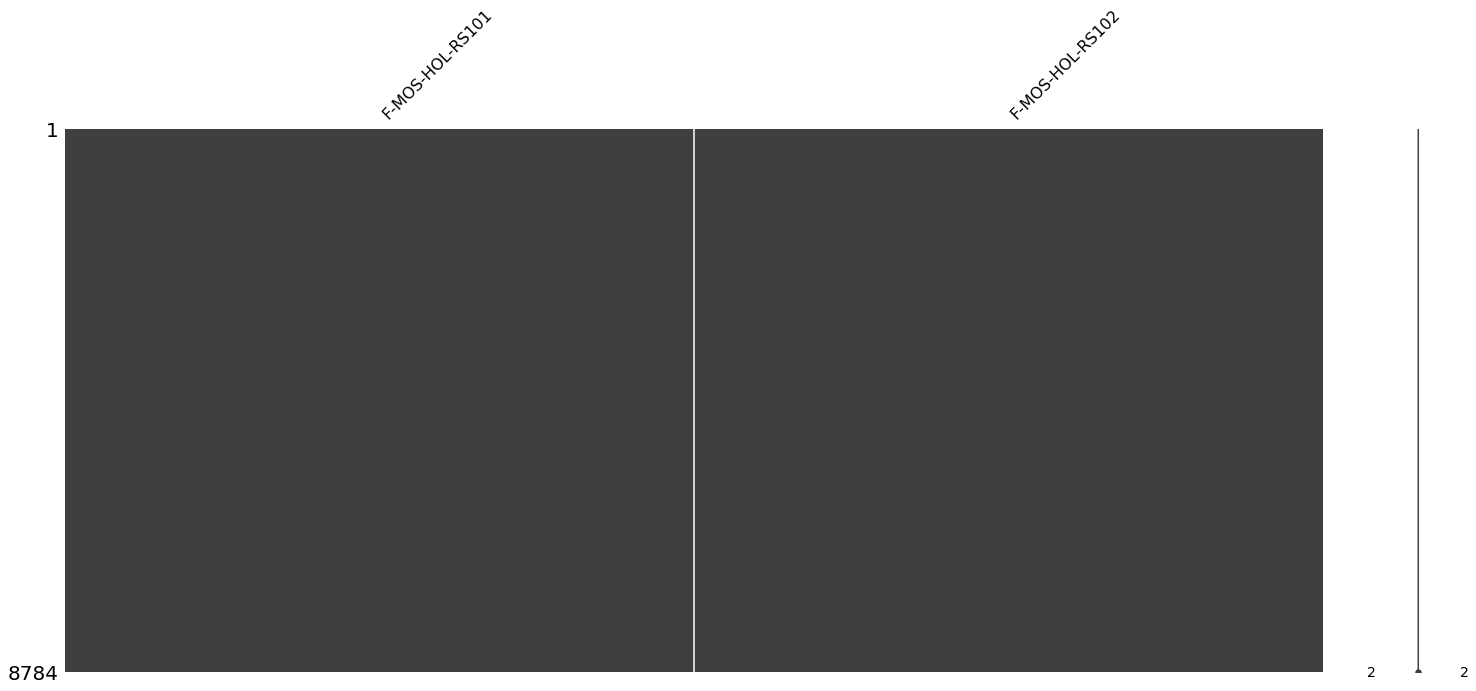

In [11]:
from missingno import matrix
test_matrix = list_flow[0].pivot_table(values='Val',columns = 'Name',index = 'CTime')
tmp_index = pd.date_range(datetime.datetime(2020,1,1,0,0,0),datetime.datetime(2020,12,31,23,59,59),freq='1h')
matrix(test_matrix.reindex(tmp_index))